# Exploratory Data Analisys

### Imports

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sbn   
import scipy.stats as ss

### Load dataset

In [6]:
try:
    df = pd.read_csv('../resources/dataset/NF-UNSW-NB15-v3.csv')
    print('Dataset loaded')
except FileNotFoundError:
    print('File not found. Remember to place the dataset in resources/dataset')

Dataset loaded


### Dataset Shape

In [ ]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

print(df.head().T)


#print("\nDataset infos:") 
print(df.info())

NameError: name 'df' is not defined

### Missing values

In [8]:
null_vals = df.isnull().sum()
print("\nMissing values per column (none for other columns):")
print(null_vals[null_vals > 0])


Missing values per column (none for other columns):
SRC_TO_DST_SECOND_BYTES    63425
dtype: int64


### Handling Zero-Duration Flows
When FLOW_DURATION_MILLISECONDS is zero, throughput features such as SRC_TO_DST_SECOND_BYTES and DST_TO_SRC_SECOND_BYTES often result in NaN or Inf values. This is expected, as the calculation of throughput involves division by the flow's duration. 

In [9]:
df_zero_duration = df[df['FLOW_DURATION_MILLISECONDS'] == 0].copy()

print(f"\nNumber of flows with FLOW_DURATION_MILLISECONDS == 0: {len(df_zero_duration)}")

print("\nValues in 'SRC_TO_DST_SECOND_BYTES' when flow duration is 0:")
nan_src_count = df_zero_duration['SRC_TO_DST_SECOND_BYTES'].isnull().sum()
print(f"  Number of NaN: {nan_src_count}")

inf_src_count = np.isinf(df_zero_duration['SRC_TO_DST_SECOND_BYTES']).sum()
print(f"  Number of Inf: {inf_src_count}")

finite_src_count = np.isfinite(df_zero_duration['SRC_TO_DST_SECOND_BYTES']).sum()
print(f"  Number of finite values (not NaN, not Inf): {finite_src_count}")

print(f"  Total: {nan_src_count+inf_src_count+finite_src_count}")

print("\nValues in 'DST_TO_SRC_SECOND_BYTES' when flow duration is 0:")
nan_dst_count = df_zero_duration['DST_TO_SRC_SECOND_BYTES'].isnull().sum()
print(f"  Number of NaN: {nan_dst_count}")

inf_dst_count = np.isinf(df_zero_duration['DST_TO_SRC_SECOND_BYTES']).sum()
print(f"  Number of Inf: {inf_dst_count}")

finite_dst_count = np.isfinite(df_zero_duration['DST_TO_SRC_SECOND_BYTES']).sum()
print(f"  Number of finite values (not NaN, not Inf): {finite_dst_count}")

print(f"  Total: {nan_dst_count + inf_dst_count + finite_dst_count}")

print("\nExample of rows with zero duration (first 5):")
print(df_zero_duration[['FLOW_DURATION_MILLISECONDS', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES']].head())



Number of flows with FLOW_DURATION_MILLISECONDS == 0: 122493

Values in 'SRC_TO_DST_SECOND_BYTES' when flow duration is 0:
  Number of NaN: 63425
  Number of Inf: 59068
  Number of finite values (not NaN, not Inf): 0
  Total: 122493

Values in 'DST_TO_SRC_SECOND_BYTES' when flow duration is 0:
  Number of NaN: 0
  Number of Inf: 122493
  Number of finite values (not NaN, not Inf): 0
  Total: 122493

Example of rows with zero duration (first 5):
    FLOW_DURATION_MILLISECONDS  SRC_TO_DST_SECOND_BYTES  \
40                           0                      NaN   
63                           0                      inf   
71                           0                      NaN   
81                           0                      inf   
97                           0                      inf   

    DST_TO_SRC_SECOND_BYTES  
40                      inf  
63                      inf  
71                      inf  
81                      inf  
97                      inf  


Before removing rows with NaN or Inf values, we must verify that the distribution of the target variable is not significantly altered.

### Target variable analysis

In [10]:
attack_cat = df['Attack']

print("Attack categories:")
print(attack_cat.unique())

Attack categories:
['Benign' 'Fuzzers' 'Exploits' 'Backdoor' 'Reconnaissance' 'Generic' 'DoS'
 'Shellcode' 'Analysis' 'Worms']


In [11]:
print("Distribution of attacks categories:")
print(attack_cat.value_counts(normalize=True) * 100)

Distribution of attacks categories:
Attack
Benign            94.601687
Exploits           1.807202
Fuzzers            1.429596
Generic            0.830760
Reconnaissance     0.721816
DoS                0.252809
Backdoor           0.196963
Shellcode          0.100658
Analysis           0.051830
Worms              0.006680
Name: proportion, dtype: float64


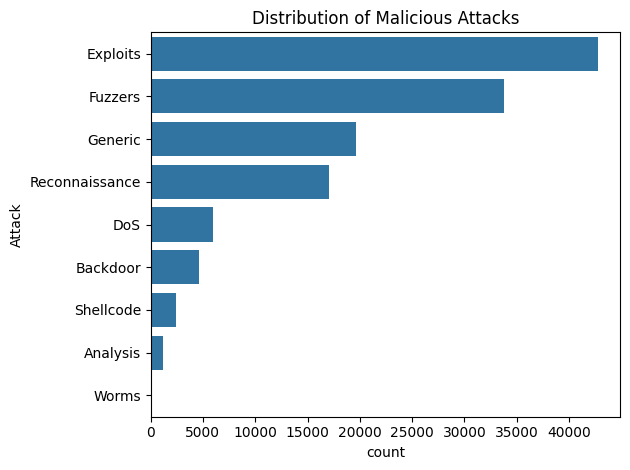

In [12]:
plt.figure()
malicious = attack_cat[attack_cat != 'Benign']
sbn.countplot(y='Attack', data=df, order = malicious.value_counts().index)
plt.title('Distribution of Malicious Attacks')
plt.tight_layout()
plt.show()

In [13]:
print("Distribution of targer variable (label):")
print(df['Label'].value_counts(normalize=True) * 100)

Distribution of targer variable (label):
Label
0    94.601687
1     5.398313
Name: proportion, dtype: float64


In [14]:
numerical_features = df.select_dtypes(include=np.number).columns.to_list()
categorical_features = df.select_dtypes(include=object).columns.tolist()

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

Numerical features (52): ['FLOW_START_MILLISECONDS', 'FLOW_END_MILLISECONDS', 'L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES', 'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS', 'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT', 'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES', 'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES', 'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', 'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE', 'DNS_TTL_ANSWER', 'FTP_COMMAND_RET_CODE', 'SRC_TO_DST_IAT_MIN', 'SRC_TO_DST_IAT_MAX', 'SRC_TO_DST_IAT_AVG', 'SRC_TO_DST_IAT_STDDEV', 'DST_TO_S

### Dealing with inf and NaN values
It's necessary to verify that removing rows containing inf or NaN values maintains an acceptable (or representative) distribution of attack types.

In [15]:
df_cleaned = df.copy()
initial_row_count = len(df)

for col in numerical_features:
    df_cleaned[col] = df_cleaned[col].replace([np.inf, -np.inf], np.nan)

df_cleaned.dropna(subset=numerical_features, inplace=True)

rows_removed = initial_row_count - len(df_cleaned)
print(f"Number of removed rows: {rows_removed} ({rows_removed / initial_row_count * 100}% of the dataset)")

print("\nDistribution of attack categories after cleaning:")
print(df_cleaned['Attack'].value_counts(normalize=True) * 100)

print("\nDistribution of targer variable (label) after cleaning:")
print(df_cleaned['Label'].value_counts(normalize=True) * 100)

Number of removed rows: 122493 (5.178479629867627% of the dataset)

Distribution of attack categories after cleaning:
Attack
Benign            95.902504
Exploits           1.730593
Fuzzers            1.140829
Reconnaissance     0.503404
DoS                0.225152
Generic            0.212222
Backdoor           0.153861
Shellcode          0.070711
Analysis           0.054661
Worms              0.006063
Name: proportion, dtype: float64

Distribution of targer variable (label) after cleaning:
Label
0    95.902504
1     4.097496
Name: proportion, dtype: float64


It is safe to remove rows with Inf or NaN values

### Stochastic Noise

In [16]:
desc_stats = df_cleaned[numerical_features].describe().T
desc_stats['CV (Std/Mean)'] = desc_stats['std'] / abs(desc_stats['mean']) 
desc_stats_sorted_cv = desc_stats.sort_values(by='CV (Std/Mean)', ascending=False)

print("Stats and Coefficient of variation CV")
print(desc_stats_sorted_cv[['mean', 'std', 'CV (Std/Mean)']].head(10)) # Only top 10 by CV

Stats and Coefficient of variation CV
                                    mean           std  CV (Std/Mean)
DNS_TTL_ANSWER              25485.763545  8.500518e+06     333.539842
DST_TO_SRC_IAT_MIN              0.006174  1.758843e+00     284.896644
SRC_TO_DST_IAT_MIN              6.047595  2.598746e+02      42.971568
RETRANSMITTED_IN_BYTES       1666.030628  3.472722e+04      20.844286
IN_BYTES                     4643.782454  6.951611e+04      14.969718
SRC_TO_DST_IAT_AVG             25.862653  2.743725e+02      10.608830
DNS_QUERY_TYPE                  0.132135  8.779334e-01       6.644230
DURATION_IN                   603.213414  3.590699e+03       5.952618
FLOW_DURATION_MILLISECONDS    611.428536  3.594194e+03       5.878355
NUM_PKTS_256_TO_512_BYTES       1.514861  7.382664e+00       4.873492


### Outliers

In [17]:
numerical_cols = df_cleaned.select_dtypes(include=np.number).columns

outlier_summary = []

for col in numerical_cols: # Interquartile range method
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    num_outliers = len(outliers)
    perc_outliers = (num_outliers / len(df[col].dropna())) * 100 

    if num_outliers > 0: 
        outlier_summary.append({
            'Column': col,
            'Number of Outlier': num_outliers,
            'Outlier Rate (%)': round(perc_outliers, 2)
        })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df.sort_values(by='Outlier Rate (%)', ascending=False)

print("Outliers Table (IQR method):")
print(outlier_df)

Outliers Table (IQR method):
                         Column  Number of Outlier  Outlier Rate (%)
15               MIN_IP_PKT_LEN             575104             24.31
14            SHORTEST_FLOW_PKT             571445             24.16
8              CLIENT_TCP_FLAGS             562382             23.78
7                     TCP_FLAGS             562339             23.77
1                      PROTOCOL             560154             23.68
13                      MAX_TTL             500712             21.17
27   NUM_PKTS_512_TO_1024_BYTES             465297             19.67
34         FTP_COMMAND_RET_CODE             440126             18.61
41           DST_TO_SRC_IAT_AVG             393551             16.64
31                 DNS_QUERY_ID             380544             16.09
32               DNS_QUERY_TYPE             380522             16.09
33               DNS_TTL_ANSWER             366640             15.50
37           SRC_TO_DST_IAT_AVG             360754             15.25
10   

## Correlation

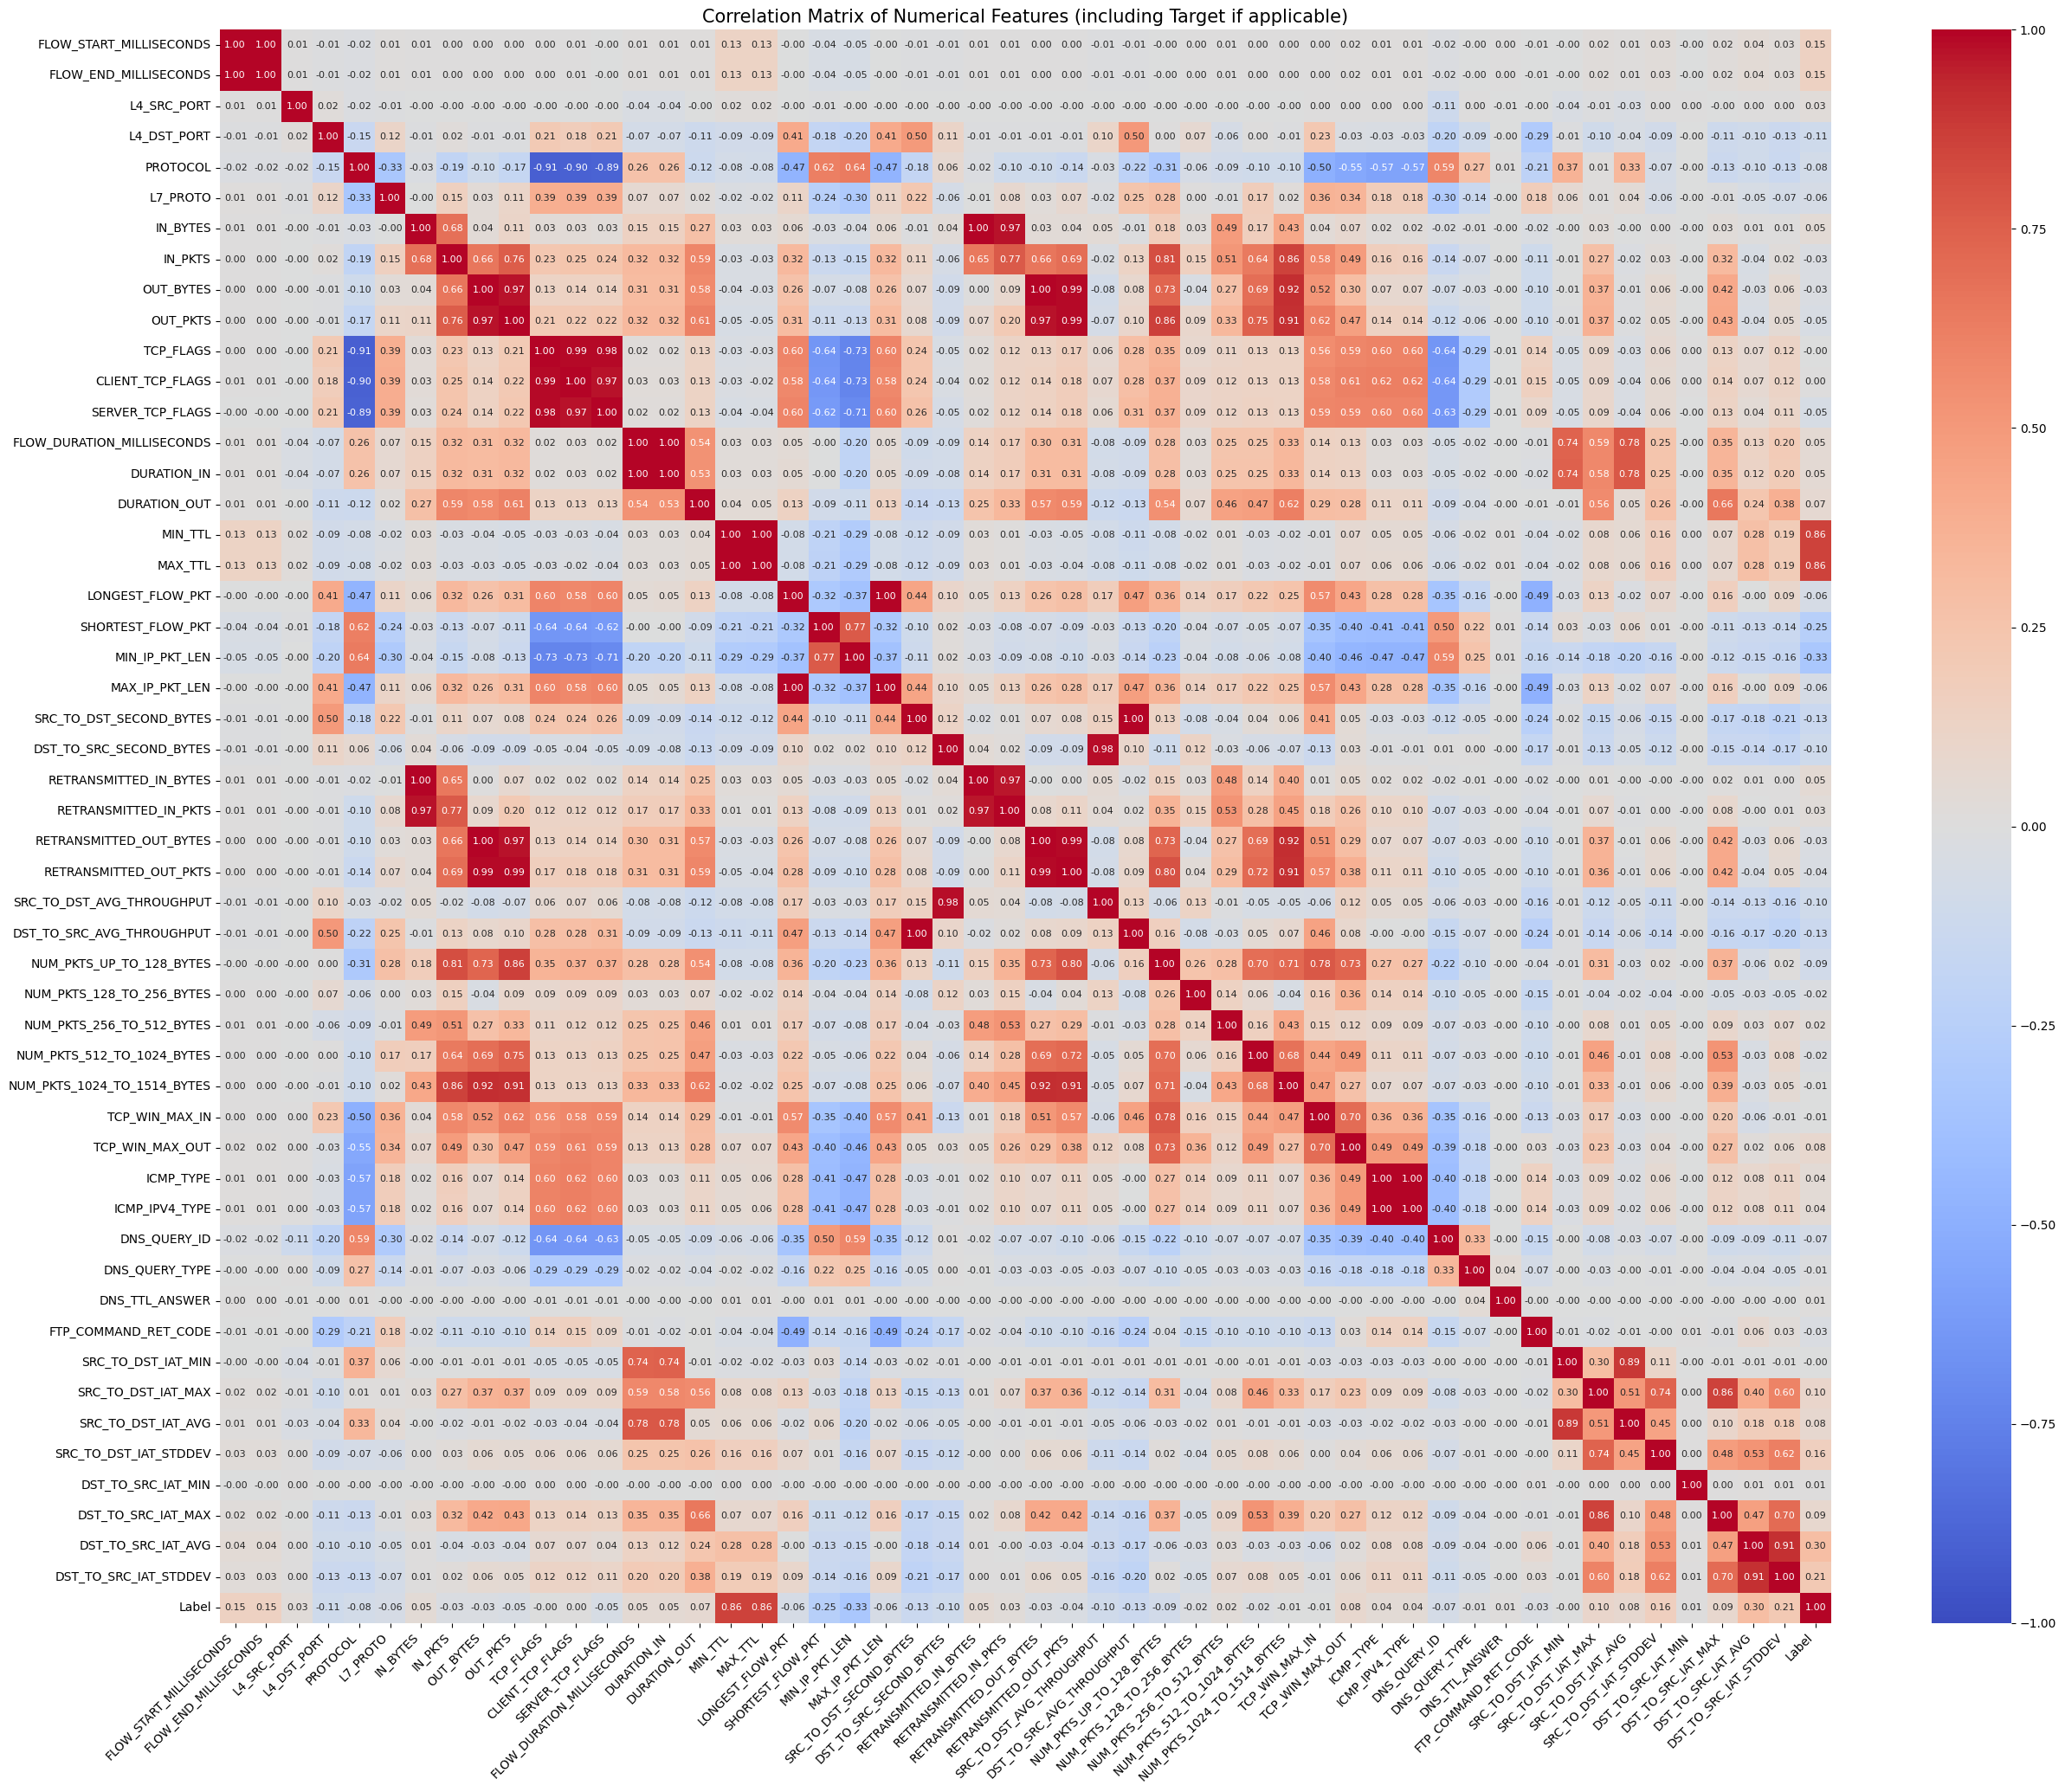

In [18]:
correlation_matrix = df_cleaned[numerical_features].corr() #Pearson by default

plt.figure(figsize=(max(10, len(numerical_features)*0.5), max(8, len(numerical_features)*0.4))) 
sbn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8}, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features (including Target if applicable)', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() 
plt.show()

### Most correlated features

In [19]:
threshold = 0.8

# To avoid duplucates like (A,B), (B,A) and (A,A) 
highly_correlated_pairs = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i, len(correlation_matrix.columns)):
        # Get the feature names
        feature_a = correlation_matrix.columns[i]
        feature_b = correlation_matrix.columns[j]

        # Skip self-correlation (correlation of a feature with itself)
        if feature_a == feature_b:
            continue

        # Get the correlation value
        correlation_value = correlation_matrix.iloc[i, j]

        if abs(correlation_value) > threshold:
            print(f"- ({feature_a}, {feature_b}): {correlation_value:.2f}")


- (FLOW_START_MILLISECONDS, FLOW_END_MILLISECONDS): 1.00
- (PROTOCOL, TCP_FLAGS): -0.91
- (PROTOCOL, CLIENT_TCP_FLAGS): -0.90
- (PROTOCOL, SERVER_TCP_FLAGS): -0.89
- (IN_BYTES, RETRANSMITTED_IN_BYTES): 1.00
- (IN_BYTES, RETRANSMITTED_IN_PKTS): 0.97
- (IN_PKTS, NUM_PKTS_UP_TO_128_BYTES): 0.81
- (IN_PKTS, NUM_PKTS_1024_TO_1514_BYTES): 0.86
- (OUT_BYTES, OUT_PKTS): 0.97
- (OUT_BYTES, RETRANSMITTED_OUT_BYTES): 1.00
- (OUT_BYTES, RETRANSMITTED_OUT_PKTS): 0.99
- (OUT_BYTES, NUM_PKTS_1024_TO_1514_BYTES): 0.92
- (OUT_PKTS, RETRANSMITTED_OUT_BYTES): 0.97
- (OUT_PKTS, RETRANSMITTED_OUT_PKTS): 0.99
- (OUT_PKTS, NUM_PKTS_UP_TO_128_BYTES): 0.86
- (OUT_PKTS, NUM_PKTS_1024_TO_1514_BYTES): 0.91
- (TCP_FLAGS, CLIENT_TCP_FLAGS): 0.99
- (TCP_FLAGS, SERVER_TCP_FLAGS): 0.98
- (CLIENT_TCP_FLAGS, SERVER_TCP_FLAGS): 0.97
- (FLOW_DURATION_MILLISECONDS, DURATION_IN): 1.00
- (MIN_TTL, MAX_TTL): 1.00
- (MIN_TTL, Label): 0.86
- (MAX_TTL, Label): 0.86
- (LONGEST_FLOW_PKT, MAX_IP_PKT_LEN): 1.00
- (SRC_TO_DST_SECOND_

### Correlation with target variable

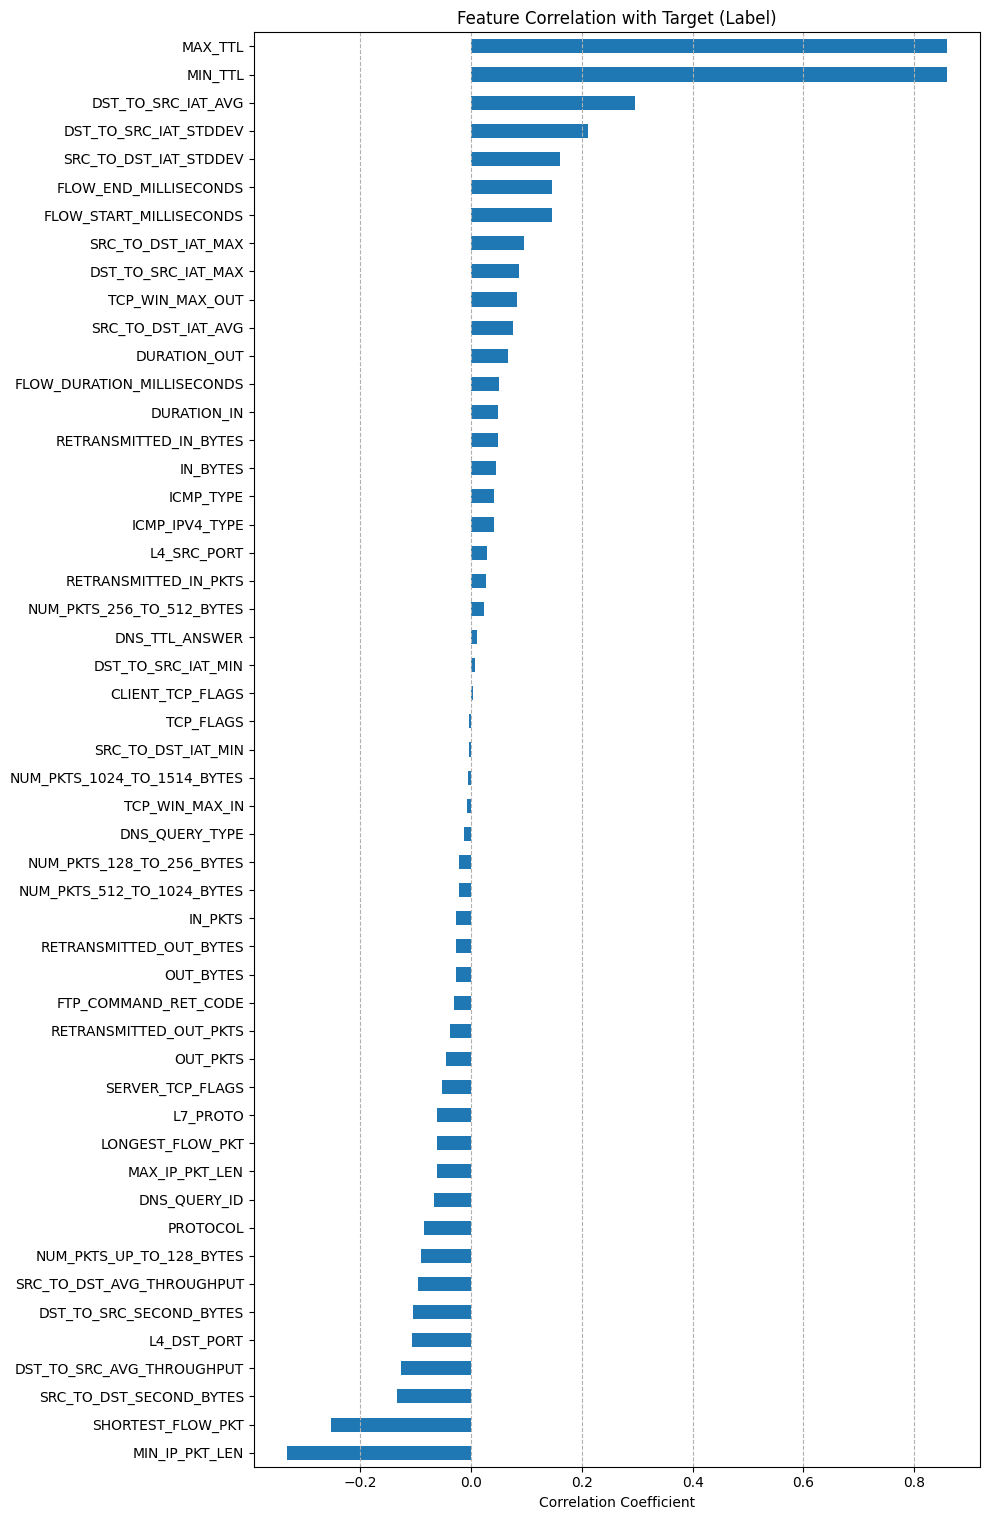

In [20]:
target_correlations = correlation_matrix['Label'].drop('Label').sort_values()
plt.figure(figsize=(10, max(6, len(target_correlations) * 0.3)))
target_correlations.plot(kind='barh')
plt.title('Feature Correlation with Target (Label)')
plt.xlabel('Correlation Coefficient')
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

There is a huge correlation between MAX_TTL, MIN_TTL and the Label. Probably that's because different operative systems has been used for attacks and non-attacks, so different ttl has been set (Windows: 128, Linux: 64)